Coupling map:


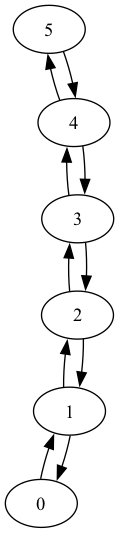

In [1]:
from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector, Parameter
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = [Parameter(f"ϕ_{i}") for i in range(num_qubits)]
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

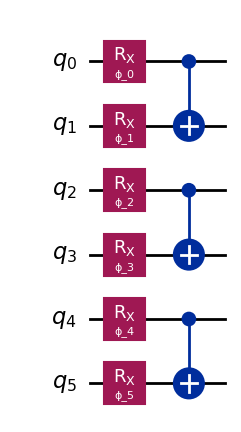

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {Parameter(ϕ_0): 4.665466064857704, Parameter(ϕ_1): 3.4958331672967256, Parameter(ϕ_2): 1.1607433119572852, Parameter(ϕ_3): 3.9246618340416872, Parameter(ϕ_4): 0.8148633976847353, Parameter(ϕ_5): 6.110646020345377}


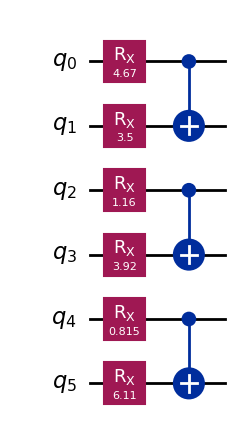

In [3]:
seed = 20983
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


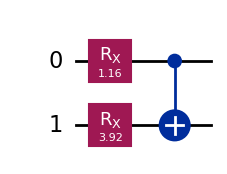

In [4]:
from rl_qoc.helpers import causal_cone_circuit

causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0].draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

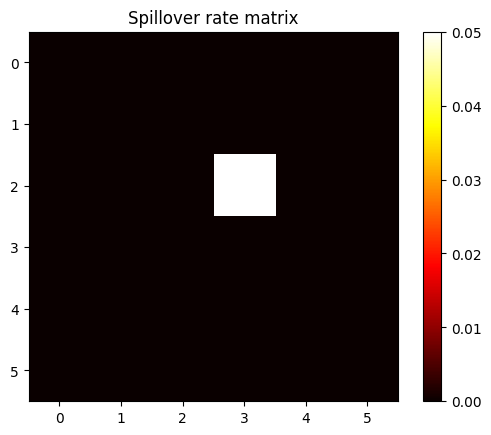

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.0  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.0  # γ_2->2
gamma_matrix[2, 3] = 0.05  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# gamma_matrix = 0.05 * np.eye(num_qubits)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

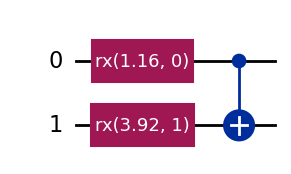

In [7]:
pass_ = LocalSpilloverNoiseAerPass(
    spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
    target_subsystem=(2, 3),
)
pm = PassManager([pass_])
qc_noisy = causal_cone_circuit(circuit.assign_parameters(param_dict), [2, 3])[0]
qc_noisy = pm.run(qc_noisy)
qc_noisy.draw("mpl")

In [8]:
qc_noisy.data

[CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[0.83625892+0.j        , 0.        -0.54833478j],
       [0.        -0.54833478j, 0.83625892+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 2),), clbits=()), CircuitInstruction(operation=Instruction(name='unitary', num_qubits=1, num_clbits=0, params=[array([[-0.38160732+0.j        ,  0.        -0.92432454j],
       [ 0.        -0.92432454j, -0.38160732+0.j        ]])]), qubits=(Qubit(QuantumRegister(6, 'q'), 3),), clbits=()), CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(6, 'q'), 2), Qubit(QuantumRegister(6, 'q'), 3)), clbits=())]

In [9]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [10]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '9bf90b100ca44ccbaea186df850ad5ad',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99957899+0.j        , 0.        -0.02901451j],
              [0.        -0.02901451j, 0.99957899+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [11]:
from qiskit.transpiler import generate_preset_pass_manager

full_pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
custom_translation_pass = PassManager([pass_] + full_pm.translation._tasks[0])
full_pm.translation = custom_translation_pass

In [12]:
full_pm.translation._tasks

[[<spillover_effect_on_subsystem.LocalSpilloverNoiseAerPass at 0x14fde7690>,

In [13]:
print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [14]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '9bf90b100ca44ccbaea186df850ad5ad',
   'operations': ['rx(3.92, 1)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99957899+0.j        , 0.        -0.02901451j],
              [0.        -0.02901451j, 0.99957899+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [15]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


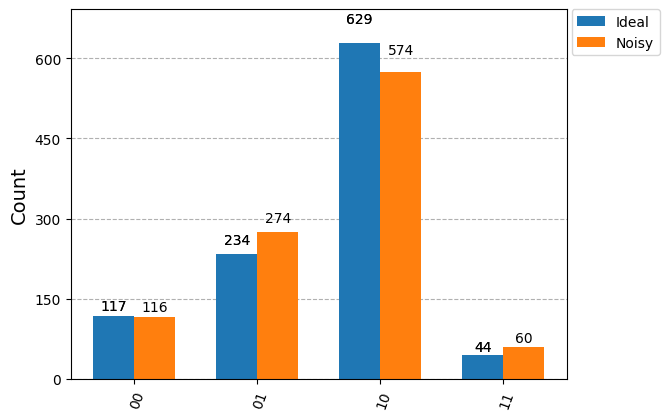

In [16]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [17]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [18]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9993265265528055

In [19]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [20]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig
from arbitrary_angle_spillover_env import (
    ArbitraryAngleSpilloverEnv,
)
# from gate_level.spillover_noise_use_case.generic_spillover.local_spillover_env import (
#     LocalSpilloverEnvironment,
# )

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}

action_space = Box(low=-0.5, high=0.5, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [2, 3]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=full_pm,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[5,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="channel",
    env_metadata=env_metadata,
)
# q_env = LocalSpilloverEnvironment(
#     q_env_config,
#     circuit_context=circuit.assign_parameters(param_dict),  # Pass the circuit already transpiled through custom pass
# )
q_env = ArbitraryAngleSpilloverEnv(
    q_env_config, unbound_circuit_context=circuit, gamma_matrix=gamma_matrix
)

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [21]:
from typing import Optional, Dict, Any, SupportsFloat
from rl_qoc.environment.context_aware_quantum_environment import ObsType, ActType

class OneParamAngleSpilloverEnv(ContextAwareQuantumEnvironment):
    """
    Quantum environment with spillover noise on a subsystem where each epoch will have a random set of angles.
    The input circuit context of this environment is expected to have symbolic Parameters for all rotation axes.
    It also should have the form of one layer of single qubit rotation gates (rx, ry, rz) and a layer of two-qubit gates.
    Binding of those parameters will be done automatically at the reset of the environment.
    """

    def __init__(
        self,
        q_env_config: QEnvConfig,
        unbound_circuit_context: QuantumCircuit,
        gamma_matrix: np.ndarray,
        num_params,
        discrete_history_length,
        circuit_param_distribution: Optional[str] = "uniform",
        optimal_error_precision: Optional[float] = 1e-4,
    ):
        """
        Initialize the environment
        """
        self.num_params = num_params
        self.circuit_param_distribution = circuit_param_distribution
        self.optimal_error_precision = optimal_error_precision
        self.discrete_history_length = discrete_history_length
        self.gamma_matrix = gamma_matrix
        self.circuit_parameters = unbound_circuit_context.parameters

        super().__init__(q_env_config, unbound_circuit_context)
        self._rotation_angles_rng = np.random.default_rng(
            self.np_random.integers(2**32)
        )
        self.observation_space = Box(
            low=np.array([-np.pi] * 1),
            high=np.array([np.pi] * 1),
            dtype=np.float64,
        )

        self.discrete_reward_history = np.ones((discrete_history_length, self.num_params))
        self.discrete_obs_vals = np.linspace(
            self.observation_space.low, self.observation_space.high, self.num_params
        ).flatten()
        print(f"Observation Vals: {self.discrete_obs_vals}")
        self.obs_angles = np.zeros(self.observation_space.shape)

    def define_target_and_circuits(self):
        """
        Define the target gate and the circuits to be executed
        """
        circuit_context = causal_cone_circuit(
            self.circuit_context, list(self.config.env_metadata["target_subsystem"])
        )[0]
        self._physical_target_qubits = list(range(circuit_context.num_qubits))
        self._circuit_context = circuit_context
        target, custom_circuits, baseline_circuits = (
            super().define_target_and_circuits()
        )

        return target, custom_circuits, baseline_circuits

    def reset(
        self,
        debug_obs: Optional[np.ndarray] = None,
        *,
        seed: Optional[int] = None,
        options: Optional[Dict[str, Any]] = None,
    ) -> tuple[ObsType, dict[str, Any]]:
        """
        Reset the environment
        :param seed: Seed for the environment
        :param options: Options for the environment
        :return: Initial observation and info
        """

        # Reset the environment
        old_angles, info = super().reset(seed=seed, options=options)

        if debug_obs is not None:
            self.obs_angles = debug_obs
        else:
            self.obs_angles = self._get_new_angles()

        phi = np.zeros(self.unbound_circuit_context.num_qubits)
        phi[2] = self.obs_angles[0]
        # phi[3] = self.obs_angles[0]

        param_dict = {self.circuit_parameters[i].name: phi[i] for i in range(len(phi))}
        circuit = self.unbound_circuit_context.assign_parameters(param_dict)
        backend = noisy_backend(
            circuit, self.gamma_matrix, self.config.env_metadata["target_subsystem"]
        )
        # Generate the initial observation
        self.set_circuit_context(None, backend=backend, **param_dict)
        env_obs = self._get_obs()
        print("Sampled angles: ", phi)
        print(f"Environment Observation: {env_obs}")
        # Return the initial observation and info
        return env_obs, {}
    
    def _get_new_angles(self):
        if self.circuit_param_distribution == "uniform":
            angles = np.random.uniform(
                self.observation_space.low, self.observation_space.high, self.observation_space.shape
            )
        if self.circuit_param_distribution == "simple_discrete":
            self.prob_weights = np.ones_like(self.discrete_obs_vals)
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                p=self.prob_weights,
                replace=True
            )
        if self.circuit_param_distribution == "moving_discrete":
            self.prob_weights = (np.mean(
                self.discrete_reward_history, axis=0
            ) + np.log10(self.optimal_error_precision)) ** 2
            self.prob_weights /= np.sum(self.prob_weights)
            angles = np.random.choice(
                a=self.discrete_obs_vals, 
                size=len(self.observation_space.shape), 
                replace=True,
                p=self.prob_weights
            )
        return angles
    
    def step(
        self, action: ActType
    ) -> tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]:

        print(f"batch action shape: {action.shape}")
        
        obs, reward, terminated, truncated, info = super().step(action)
        print(f"obs: {obs}")
        print(f"reward: {reward}")

        self.update_discrete_history(reward, obs)

        return obs, reward, terminated, truncated, info
    
    def update_discrete_history(self, reward, obs):
        obs_ind = np.argmin(np.abs(self.discrete_obs_vals - obs * np.pi))
        self.discrete_reward_history[:, obs_ind] = np.append(
            [np.mean(reward)], self.discrete_reward_history[:-1, obs_ind], axis=0
        )
    
    # def initialize_discrete_history(self):
    #     # Initializes Discrete History with success of zeros policy
    #     for set_obs in np.tile(self.discrete_obs_vals, (self.discrete_history_length,)):
    #         _obs, info = self.reset(debug_obs=np.array([set_obs]))
    #         obs, reward, terminated, truncated, info = self.step(np.zeros((self.batch_size,) + self.action_space.shape))
    
    def clear_history(self):
        super().clear_history()
        self.discrete_reward_history = np.ones_like(self.discrete_reward_history)

    def _get_obs(self):
        """
        Get the observation
        :return: Observation
        """
        return self.obs_angles / np.pi # Normalized to multiples of pi

    def _get_info(self) -> Any:
        return {}

In [22]:
alt_q_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [23]:
rescaled_q_env = RescaleAndClipAction(alt_q_env, min_action=-1., max_action=1.)

In [24]:
rescaled_q_env.action_space

Box(-0.5, 0.5, (7,), float32)

In [25]:
rescaled_q_env.action_space.low

array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5], dtype=float32)

In [26]:
rescaled_q_env.action_space.high

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], dtype=float32)

In [27]:
# Testing action behaviour

input_action = np.ones(7)
output_action = rescaled_q_env.action(input_action)

print(output_action)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [28]:
print(alt_q_env.batch_size)

32


In [29]:
# Testing n-reps fitting

from typing import Callable, Any, Optional, List, Literal
from scipy.optimize import curve_fit

def _fit_function(n, eps_quad):
    return 3/5 + 2/5 * np.cos(n * eps_quad)

def _fit_function_2(n, delta_1, delta_2):
    return (4 * np.cos(n * delta_1)**2 * np.cos(n * delta_2)**2 + 1) / 5

def _inverse_fit_function(reward, n, spam, eps_lin, eps_quad):
    return reward + eps_lin * (n - 1) + eps_quad * (n**2 - 1)

def custom_reward_fit(
    env,
    params: np.array,
    execution_config: Optional[ExecutionConfig] = None,
    fit_function: Optional[Callable] = None,
    inverse_fit_function: Optional[Callable] = None,
    update_fit_params: bool = True,
    reward_method: Optional[
        Literal["cafe", "channel", "orbit", "state", "xeb", "fidelity"]
    ] = None,
) -> plt.Figure:
    """
    Method to fit the initial reward function to the first set of actions in the environment
    with respect to the number of repetitions of the cycle circuit
    """

    initial_execution_config = env.config.execution_config
    initial_reward_method = env.config.reward_method
    if execution_config is not None:
        env.config.execution_config = execution_config
    if reward_method is not None:
        env.config.reward_method = reward_method
    reward_data = []
    for i in range(len(env.config.execution_config.n_reps)):
        env.config.execution_config.n_reps_index = i
        reward = env.perform_action(params, update_env_history=False)
        reward_data.append(np.mean(reward))
    if fit_function is None or inverse_fit_function is None:
        fit_function = _fit_function
        inverse_fit_function = _inverse_fit_function

    p0 = [0.015,]  # Initial guess for the parameters
    lower_bounds = [0.0,]
    upper_bounds = [10.,]

    popt, pcov = curve_fit(
        fit_function,
        env.config.execution_config.n_reps,
        reward_data,
        p0=p0,
        bounds=(lower_bounds, upper_bounds),
    )

    # Create a figure and return it to the user
    fig, ax = plt.subplots()
    ax.plot(
        env.config.execution_config.n_reps, reward_data, label="Data", marker="o"
    )
    ax.plot(
        env.config.execution_config.n_reps,
        [fit_function(n, *popt) for n in env.config.execution_config.n_reps],
        label="Fit",
    )
    ax.set_xlabel("Number of repetitions")
    ax.set_ylabel("Reward")
    ax.legend()
    ax.set_title("Initial reward fit (for varying number of repetitions)")
    # Print found parameters
    print("Found parameters:", popt)

    if execution_config is not None:
        env.config.execution_config = initial_execution_config
    if reward_method is not None:
        env.config.reward_method = initial_reward_method
    if update_fit_params:
        env._fit_function = lambda reward, n: inverse_fit_function(
            reward, n, *popt
        )
        env._fit_params = popt
    return fig, reward_data

In [30]:
print(np.mean(np.zeros((32, 7)), axis=0))

[0. 0. 0. 0. 0. 0. 0.]


Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.9950680911605598 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.9573459919865591 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.8826397943700819 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.7832725837264767 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.6720290463645565 Std: 0.0
Found parameters: [0.15527659]


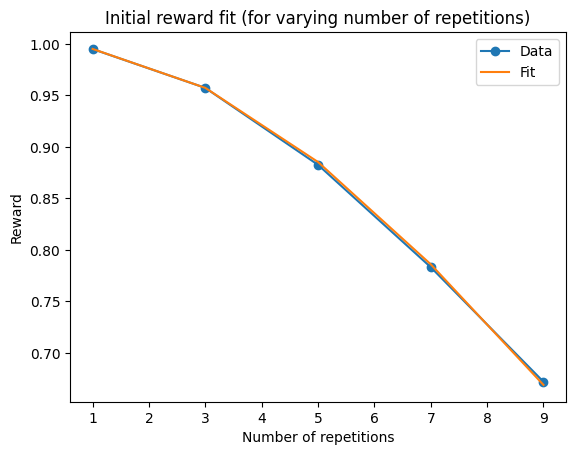

In [31]:
_obs, info = alt_q_env.reset(debug_obs=np.array([np.pi]))

fig, reward_data = custom_reward_fit(  
    alt_q_env,
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        n_reps=list(
            range(1, 10, 2),
        ),
        dfe_precision=None,
        seed=q_env_config.seed,
        control_flow_enabled=False,
    ),
    update_fit_params=False,
    reward_method=None,
)

In [32]:
baseline_reward = []

alt_q_env.clear_history()
for set_obs in alt_q_env.discrete_obs_vals:
    # _obs, info = alt_q_env.reset(debug_obs=np.array([1.]))
    _obs, info = alt_q_env.reset(debug_obs=np.array([set_obs]))
    zero_action = np.zeros((alt_q_env.batch_size,) + alt_q_env.action_space.shape)
    print(zero_action.shape)
    obs, reward, terminated, truncated, info = alt_q_env.step(zero_action)
    baseline_reward.append(np.mean(reward))
    print(f"discrete reward history: {alt_q_env.discrete_reward_history}")

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
(32, 7)
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.8848009761398987 Std: 0.010673806510288618
obs: [-1.]
reward: [0.93370633 0.94566102 0.9644927  0.96822438 0.99559608 0.91998341
 0.96740545 0.93621745 1.01886805 0.92254603 0.98449498 0.98267568
 0.9671986  0.91661621 0.85952139 0.90182806 0.86756856 0.97962374
 0.97440642 0.8763935  1.00907575 0.88149157 0.93787973 0.88723779
 0.92857675 0.97493345 0.9201312  0.91279604 0.92769559 0.93495154
 0.9467007  0.94817359]
discrete reward history: [[0.94039599 1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.     

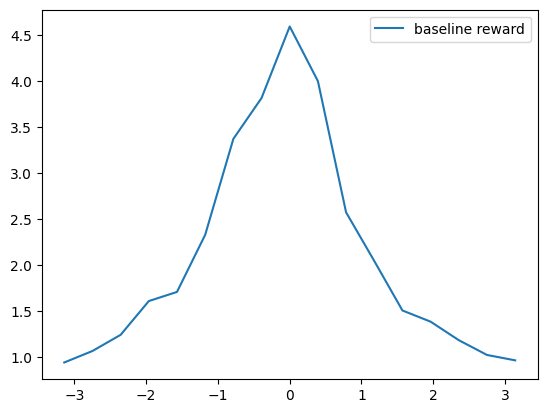

In [33]:
# plt.plot(alt_q_env.discrete_reward_history[0], label='discrete reward memory')
plt.plot(alt_q_env.discrete_obs_vals, baseline_reward, label='baseline reward')
plt.legend()
plt.show()

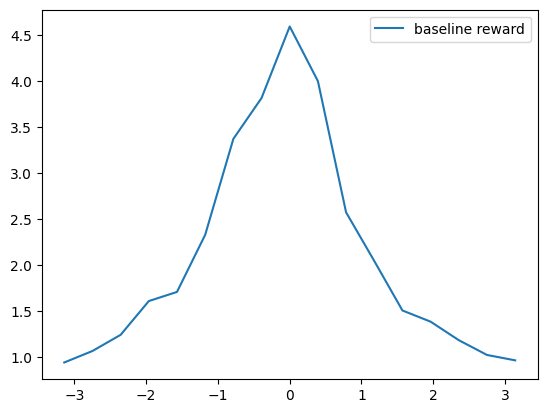

In [34]:
# plt.plot(alt_q_env.discrete_reward_history[0], label='discrete reward memory')
plt.plot(alt_q_env.discrete_obs_vals, baseline_reward, label='baseline reward')
plt.legend()
plt.show()

In [41]:
# PPO Details

from ppo_cleanrl import PPO_CleanRL

alt_q_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

agent_config = {
    "exp_name": "Test PPO CleanRL",
    "seed": 1,
    "torch_deterministic": True,
    "cuda": False,
    "track": False,
    "wandb_project_name": "Context Aware Calibrations",
    "wandb_entity": None,
    "save_model": True,
    "plot_real_time": True,
    "num_prints": 5,
    "total_updates": 400,
    "learning_rate": 3e-3,
    "num_envs": 32,
    "num_steps": 1,
    "anneal_lr": True,
    "anneal_num_updates": 1600,
    "exp_anneal_lr": False,
    "exp_update_time": 100,
    "plateau_lr": 1e-6,
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "num_minibatches": 4,
    "update_epochs": 8,
    "norm_adv": True,
    "activation_function_str": "elu",
    "use_combined_networks": False,
    "layer_size": 64,
    "clip_coef": 0.2,
    "clip_vloss": True,
    "ent_coef": 0.0,
    "vf_coef": 0.5,
    "max_grad_norm": 0.5,
    "target_kl": None,
    "robust_ppo": False,
}

# alt_q_env.clear_history()
rescaled_q_env = RescaleAndClipAction(alt_q_env, min_action=-1., max_action=1.)
ppo_agent = PPO_CleanRL(agent_config, rescaled_q_env)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [42]:
# Testing the optimal policy in advance

single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [43]:
# Testing fidelity of agents

import copy
import torch

rewards = []

# action_test = copy.deepcopy(actions)
o_vals = alt_q_env.discrete_obs_vals
ana_sum = -o_vals * 0.05 # gamma value
ana_scaled = ana_sum / 0.5 # env action space bounds

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = ppo_agent.env.unwrapped.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    # act = action_test[i]
    act = np.zeros(7)
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    act[3] = ana_scaled[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (ppo_agent.env.unwrapped.batch_size, 1))
    obs, reward, terminated, truncated, info = ppo_agent.env.step(batch_action)
    rewards.append(np.mean(reward))

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 1.001970402941525 Std: 0.013769550712273405
obs: [-1.]
reward: [3.16200069 6.         1.48275784 6.         6.         6.
 6.         2.2892564  6.         6.         6.         6.
 2.7237339  6.         2.25763027 1.9035677  1.88286035 1.96300675
 6.         6.         6.         6.         1.6466915  6.
 6.         6.         6.         6.         6.         2.65987073
 1.91981615 1.65027606]
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9962277361774309


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0021544034623946 Std: 0.013529480650996692
obs: [-0.875]
reward: [1.64026489 2.24604729 2.11418119 6.         2.07499908 3.00575539
 6.         2.51466728 2.33957924 1.99994822 6.         6.
 6.         2.81990325 6.         6.         6.         6.
 6.         6.         6.         2.81058011 1.65923074 6.
 1.46194421 6.         6.         6.         6.         6.
 6.         2.52008483]
Sampled angles:  [ 0.          0.         -2.35619449  0.          0.          0.        ]
Environment Observation: [-0.75]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9972273827819705


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9987438144801438 Std: 0.012531256456744572
obs: [-0.75]
reward: [2.7923208  6.         6.         1.92483515 6.         6.
 1.92459813 6.         2.19210718 2.49693776 2.63038637 1.68159914
 2.46668272 6.         6.         6.         6.         2.04144757
 1.72852144 6.         6.         1.99469655 1.99905765 6.
 2.10010719 2.08497584 1.82516448 6.         1.60029351 6.
 3.5426139  1.62346527]
Sampled angles:  [ 0.          0.         -1.96349541  0.          0.          0.        ]
Environment Observation: [-0.625]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9980738906688789
Reward (avg): 0.999910788163998 Std: 0.012824537337294236
obs: [-0.625]
reward: [1.99029719 6.         1.54065569 2.06937393 2.46468932 2.30316565
 1.66827192 1.79147986 6.         6.         2.03235518 6.
 6.         2.23640138 6.         6.         6.         6.
 2.20315624 2.13275717 2.11625097 6.         1.88991479 6.
 2.10725455 2.90653791 1.95973142 6.         3.30088207 2.02274888
 6.         6.        ]
Sampled angles:  [ 0.          0.         -1.57079633  0.          0.          0.        ]
Environment Observation: [-0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9987669334932511


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9974799392480902 Std: 0.012831728567958407
obs: [-0.5]
reward: [6.         6.         6.         1.98763325 1.82430402 6.
 6.         3.04600579 1.88587703 1.87078693 6.         2.03698455
 1.72178962 2.24019276 6.         1.79762519 2.17827345 1.70019492
 3.19245758 1.89482412 6.         1.52202666 6.         6.
 6.         6.         2.17590394 6.         1.8366885  2.6965558
 1.84527215 1.97584169]
Sampled angles:  [ 0.          0.         -1.17809725  0.          0.          0.        ]
Environment Observation: [-0.375]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9993062440738862
Reward (avg): 1.0018817192087361 Std: 0.016712199273100477
obs: [-0.375]
reward: [2.33221904 6.         6.         6.         6.         1.78457762
 6.         3.61871414 1.93737824 6.         1.58518304 1.61910553
 1.91211344 6.         6.         6.         1.64223267 6.
 6.         6.         6.         6.         1.56153975 6.
 6.         1.84390409 6.         1.84641321 6.         1.74407869
 6.         6.        ]
Sampled angles:  [ 0.          0.         -0.78539816  0.          0.          0.        ]
Environment Observation: [-0.25]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996916144962891


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0050039920539855 Std: 0.014985436585350254
obs: [-0.25]
reward: [6.         6.         2.32840318 1.73099114 6.         2.32526639
 6.         6.         2.14236872 3.17297052 6.         1.70203615
 1.78031972 2.82568273 6.         2.67982562 6.         2.84995183
 6.         6.         6.         6.         1.85651193 6.
 6.         3.37209674 2.35399543 2.1709874  6.         6.
 6.         6.        ]
Sampled angles:  [ 0.          0.         -0.39269908  0.          0.          0.        ]
Environment Observation: [-0.125]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9999228961928258


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9992579517127613 Std: 0.01469002860777541
obs: [-0.125]
reward: [6.         6.         6.         3.33737493 1.87121205 1.60738064
 1.86595956 2.07108322 6.         1.77417449 6.         1.4729285
 6.         1.83991035 6.         6.         2.24004421 1.80018731
 6.         6.         6.         2.81761331 2.48398    6.
 6.         2.84317954 1.96699632 1.98205837 2.18499422 2.20035675
 1.83407734 6.        ]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  1.0


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9940799057434027 Std: 0.010998849157238618
obs: [0.]
reward: [6.         1.91421985 1.70090738 2.57826284 6.         2.20691906
 1.75861729 1.99008447 1.92313052 1.6388421  2.80349239 2.1498144
 6.         2.20244    1.7550345  1.6344776  6.         2.45776516
 1.78595858 1.60709589 1.90478694 6.         1.78540504 3.31835589
 6.         6.         1.99842971 2.16207816 6.         6.
 1.89424706 6.        ]
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9999228961928258


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9938105414735317 Std: 0.01546823508310385
obs: [0.125]
reward: [6.         1.69514651 6.         1.75426031 2.64465623 6.
 1.86154631 2.89675489 1.65803348 1.75819123 1.71791447 1.62945504
 1.782864   6.         1.7990323  2.14202958 6.         2.036029
 1.76318496 1.86320205 6.         1.42696471 6.         2.06075477
 2.31637365 1.80465316 2.50442856 1.57364244 6.         1.88173404
 6.         6.        ]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996916144962891


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0017551362923007 Std: 0.013859968148218813
obs: [0.25]
reward: [2.08730059 6.         2.30382582 1.84273918 6.         2.5375601
 2.08410361 2.02786211 6.         6.         6.         6.
 6.         3.95297378 6.         2.75873003 6.         1.83483232
 6.         6.         6.         6.         2.06757119 6.
 1.61275836 2.05625695 6.         6.         6.         1.45345137
 6.         6.        ]
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9993062440738862


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0003205851675605 Std: 0.014799321001459137
obs: [0.375]
reward: [1.98201222 2.39511162 2.55262695 6.         2.32522275 2.57491239
 2.03922674 1.71915921 2.27403918 6.         6.         6.
 1.73421582 6.         1.51258364 6.         1.45103607 2.60485155
 6.         6.         6.         6.         6.         1.87704078
 6.         6.         2.49352487 1.729619   6.         6.
 2.61034798 6.        ]
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9987669334932512


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0007153861110938 Std: 0.0118363214157492
obs: [0.5]
reward: [6.         2.11462731 6.         6.         6.         6.
 6.         2.02417758 6.         2.25083256 6.         6.
 2.19966606 6.         1.96730755 2.01755521 2.13462593 2.09457174
 2.01957735 6.         2.06805147 6.         1.77263703 6.
 1.74802386 6.         1.98072162 2.18431146 6.         2.11931268
 6.         1.90189857]
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9980738906688786


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9997573357603835 Std: 0.018346274070810676
obs: [0.625]
reward: [2.28877886 2.48190773 6.         1.50655808 1.48347522 6.
 6.         6.         6.         2.4116315  2.36212617 1.49200816
 1.66149544 1.82692469 1.68774121 6.         1.69284438 6.
 2.19145536 6.         1.61919218 6.         1.94178534 6.
 6.         6.         6.         1.85016179 6.         6.
 2.61078629 2.49178825]
Sampled angles:  [0.         0.         2.35619449 0.         0.         0.        ]
Environment Observation: [0.75]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9972273827819705


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.000475534956914 Std: 0.014618718617035287
obs: [0.75]
reward: [6.         2.60467054 6.         2.01255379 2.18304114 6.
 3.22075835 1.72154713 1.87920574 6.         6.         1.69986618
 2.4880722  1.6713229  2.04410927 6.         6.         1.99635186
 2.12671431 6.         1.52811467 6.         1.8731984  6.
 2.49069995 6.         6.         6.         1.91234219 6.
 6.         6.        ]
Sampled angles:  [0.         0.         2.74889357 0.         0.         0.        ]
Environment Observation: [0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.996227736177431


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.0029493314718745 Std: 0.015699905017686696
obs: [0.875]
reward: [6.         6.         6.         6.         6.         3.01643546
 6.         1.63861654 2.94371385 6.         6.         6.
 1.78895911 1.70067143 1.76093782 6.         6.         1.46301221
 6.         6.         2.37812342 6.         6.         2.1623037
 6.         6.         6.         1.74507687 6.         6.
 1.78715383 2.14781678]
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9951594803985241 Std: 0.009972963585243272
obs: [1.]
reward: [1.83988621 1.97837406 3.58286232 2.48646209 2.46386051 6.
 6.         2.11342422 2.45998345 2.28363886 2.77769582 6.
 6.         1.86004203 2.596693   1.50343567 2.92055739 1.97446285
 1.70818925 2.58378626 3.32514378 6.         2.56817489 1.80287365
 1.61637614 3.73293612 2.72734468 1.86114157 6.         6.
 2.18751694 2.05392973]


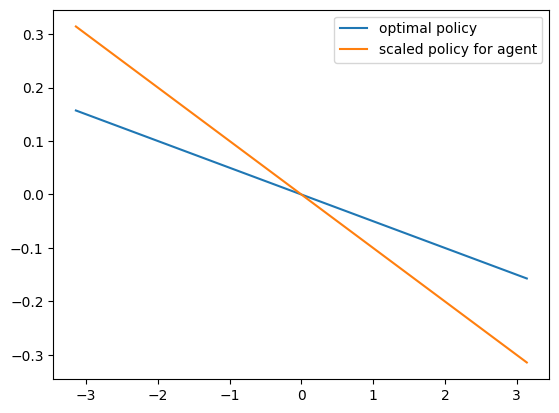

In [44]:
plt.plot(o_vals, ana_sum, label='optimal policy')
plt.plot(o_vals, ana_scaled, label='scaled policy for agent')
plt.legend()
plt.show()

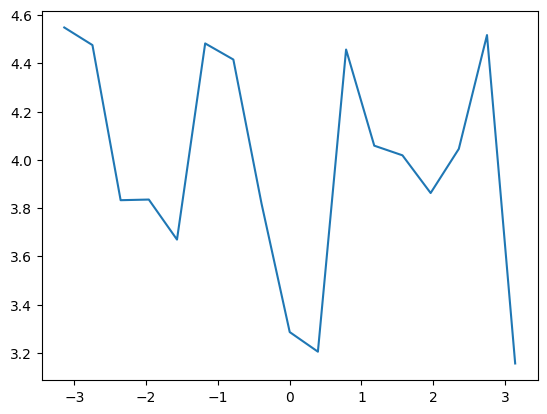

In [45]:
plt.plot(o_vals, rewards)
plt.show()

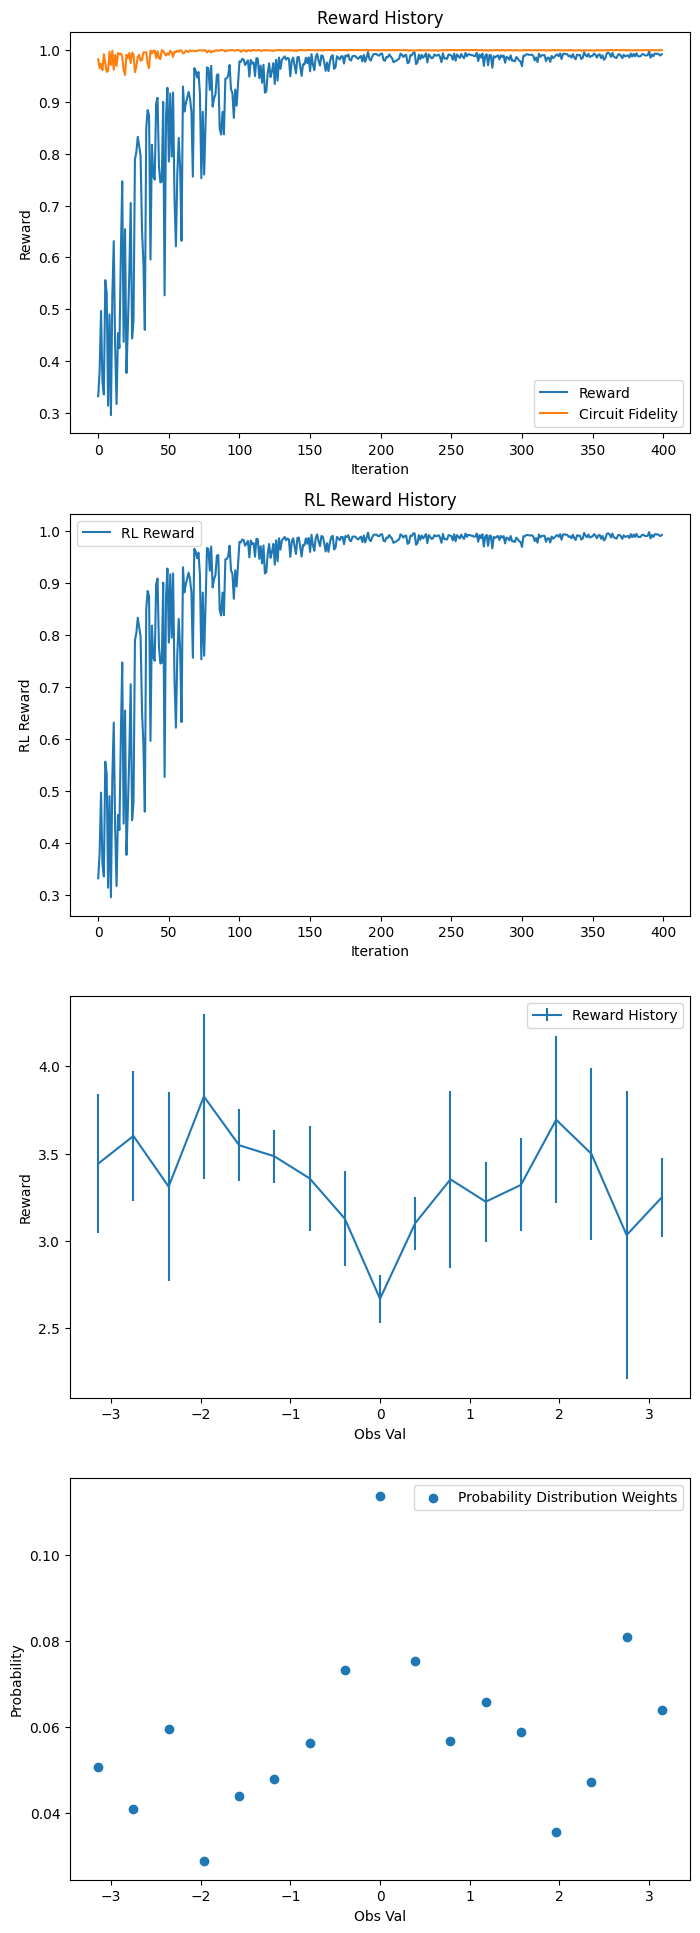

model saved to runs/PPO_CleanRL__Test PPO CleanRL__1__1742392866/Test PPO CleanRL.cleanrl_model


In [46]:
# from gymnasium.wrappers import ActionWrapper

ppo_agent.env.unwrapped.clear_history()
# ppo_agent.env.clear_history()
ppo_agent.run_training()

In [48]:
print(np.sum(ppo_agent.env.unwrapped.total_shots))

281224.58138732595


In [65]:
# New env

test_env = OneParamAngleSpilloverEnv(
    q_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [67]:
_obs, info = test_env.reset(seed=seed, debug_obs=np.array([np.pi]))

_ = test_env.step(action=np.zeros((32, 7)))

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9950753362380551
Reward (avg): 0.8969959778545351 Std: 0.010390424769652068
obs: [1.]
reward: [1.02983473 0.9722636  1.00531803 0.96022692 0.97171667 0.95371662
 0.97053258 1.07520573 1.1354108  1.01536131 0.93840734 0.96267365
 1.04498268 0.96554242 1.05127707 1.01936723 0.98125872 0.99948565
 1.00783748 0.97431776 0.96323064 0.99174039 0.96012146 0.98142106
 0.91945683 0.97178215 1.00294911 0.99341843 1.01243214 0.9744916
 0.97260162 0.8841248 ]


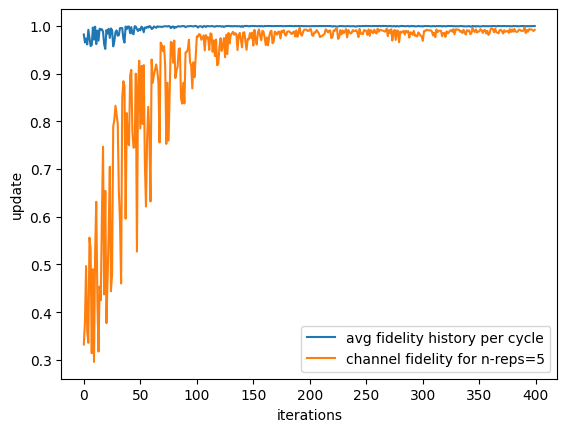

In [51]:
# Plot Average per-cycle Gate Fidelity during training

avg_fidelity_history = ppo_agent.env.unwrapped.fidelity_history
avg_fidelity_history_n_reps = ppo_agent.env.unwrapped.avg_fidelity_history_nreps
n_reps_channel_fidelity = np.mean(ppo_agent.env.unwrapped.reward_history, axis=-1)

plt.plot(avg_fidelity_history, label='avg fidelity history per cycle')
plt.plot(n_reps_channel_fidelity, label='channel fidelity for n-reps=5')
# plt.plot(avg_fidelity_history_n_reps, label='avg fidelity history n-reps')
# plt.axhline()
plt.xlabel('iterations')
plt.ylabel('update')
plt.legend()
plt.show()

In [47]:
def single_rep_fidelity(
    n_rep_fidelity,
    n
):
    a = 3/5 # depends on dim size
    b = 2/5 # depends on dim size
    coherent_error = 1/n * np.arccos((n_rep_fidelity - a) / b)
    # coherent_error = np.clip(coherent_error, a_min=0, a_max=None)
    return a + b * np.cos(coherent_error)

In [54]:
reward_history = ppo_agent.env.unwrapped.reward_history
mean_reward_history = np.mean(reward_history, axis=1)

single_rep_reward_history = single_rep_fidelity(mean_reward_history, n=5)

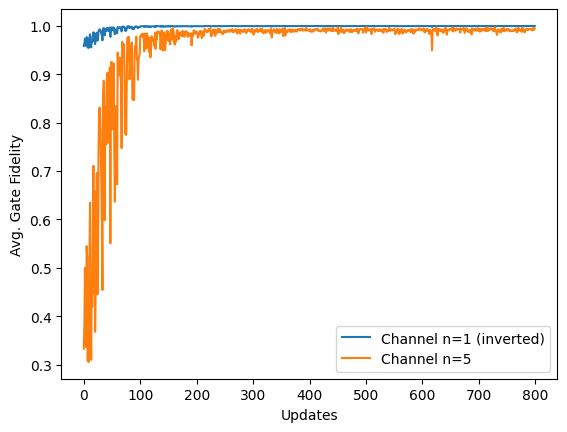

In [55]:
# Inverting channel n-reps fid to get single rep fid

plt.plot(single_rep_reward_history, label='Channel n=1 (inverted)')
plt.plot(mean_reward_history, label='Channel n=5')
plt.xlabel('Updates')
plt.ylabel('Avg. Gate Fidelity')
plt.legend()
plt.show()

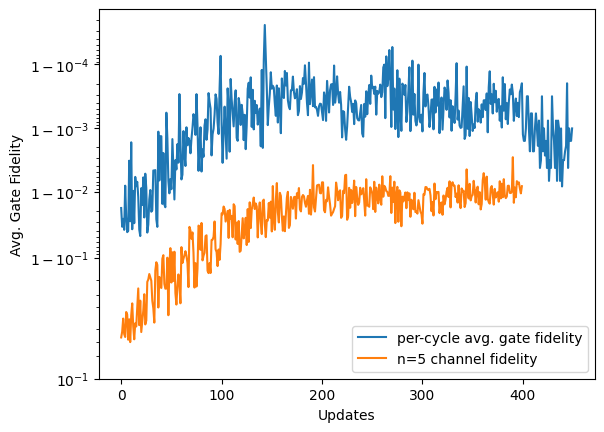

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are your data arrays
single_rep_reward_history = avg_fidelity_history
mean_reward_history = n_reps_channel_fidelity

# Replace any invalid values
single_rep_reward_history = np.nan_to_num(single_rep_reward_history, nan=0.0, posinf=1.0, neginf=0.0)
mean_reward_history = np.nan_to_num(mean_reward_history, nan=0.0, posinf=1.0, neginf=0.0)

plt.plot(single_rep_reward_history, label='per-cycle avg. gate fidelity')
plt.plot(mean_reward_history, label='n=5 channel fidelity')
plt.xlabel('Updates')
plt.ylabel('Avg. Gate Fidelity')
plt.yscale('logit')

# Set y-ticks without 0.00001
plt.yticks([0.1, 0.9, 0.99, 0.999, 0.9999])

# Format y-axis to show decimals instead of scientific notation
# plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.4f'))

plt.legend()
plt.show()

In [85]:
import torch

random_obs = np.random.choice(ppo_agent.env.unwrapped.discrete_obs_vals, size=1000, replace=True)
random_obs = np.random.uniform(-np.pi, np.pi, 5000)
print(random_obs)

[-1.31675786  2.75774734  0.9636202  ...  1.48850718 -0.28362016
  1.74373737]


In [91]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=4,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [92]:
full_reward = []

for sample_obs in random_obs:
    _obs, info = single_n_q_env.reset(debug_obs=np.array([sample_obs]))
    next_obs = torch.Tensor(np.tile(sample_obs / np.pi, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.5

    cpu_action = np.mean(cpu_action, axis=0)
    cpu_action = np.tile(cpu_action, (2, 1))
    total_action = np.concatenate(
        (cpu_action, np.zeros((2, 7))), axis=0
    )
    print(total_action.shape)

    obs, reward, terminated, truncated, info = single_n_q_env.step(total_action)
    full_reward.append(reward)

Sampled angles:  [ 0.          0.         -1.31675786  0.          0.          0.        ]
Environment Observation: [-0.41913704]
(4, 7)
batch action shape: (4, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9994564010096639
Reward (avg): 0.9994564010096639 Std: 0.00032301353422820034
obs: [-0.41913704]
reward: [3.65642313 3.65642313 3.06217504 3.06217504]
Sampled angles:  [0.         0.         2.75774734 0.         0.         0.        ]
Environment Observation: [0.87781824]
(4, 7)
batch action shape: (4, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9977486332675586
Reward (avg): 0.9977486332675586 Std: 0.0015451974189515938
obs: [0.87781824]
reward: [3.15109116 3.15109116 2.42060926 2.42060926]
Sampled angles:  [0.        0.        0.9636202 0.        0.        0.       ]
Environment Observation: [0.30672984]
(4, 7)
batch action shape: (4, 7)
Starting simulation benchmark...
Finished simulation bench

In [72]:
baseline_reward = []

for sample_obs in random_obs:
    _obs, info = single_n_q_env.reset(debug_obs=np.array([sample_obs]))
    next_obs = torch.Tensor(np.tile(sample_obs / np.pi, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.5
    zeros_action = np.zeros((2, 7))

    obs, reward, terminated, truncated, info = single_n_q_env.step(zeros_action)
    baseline_reward.append(np.mean(reward))

Sampled angles:  [ 0.          0.         -0.95542452  0.          0.          0.        ]
Environment Observation: [-0.30412107]
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9995436687819907
Reward (avg): 0.9995436687819907 Std: 0.0
obs: [-0.30412107]
reward: [3.34071982 3.34071982]
Sampled angles:  [ 0.          0.         -2.58716978  0.          0.          0.        ]
Environment Observation: [-0.82352172]
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9966579405695818
Reward (avg): 0.9966579405695818 Std: 0.0
obs: [-0.82352172]
reward: [2.47598583 2.47598583]
Sampled angles:  [ 0.          0.         -2.83648373  0.          0.          0.        ]
Environment Observation: [-0.90288081]
batch action shape: (2, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9959839184447997
Reward (avg): 0.9959839184447997 Std:

In [93]:
full_reward_arr = np.array(full_reward)

policy_reward = np.mean(full_reward_arr[:,:2], axis=-1)
baseline_reward = np.mean(full_reward_arr[:,2:], axis=-1)

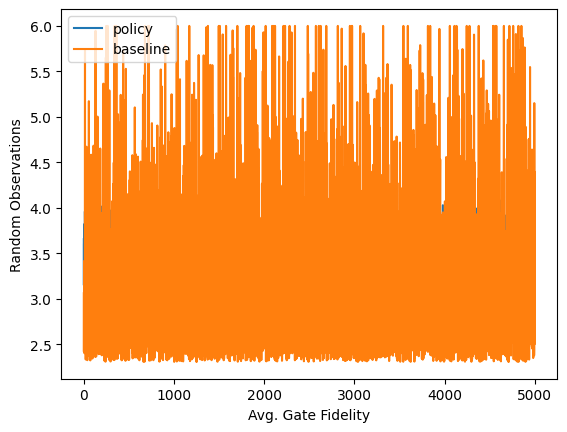

In [94]:
plt.plot(policy_reward, label='policy')
plt.plot(baseline_reward, label='baseline')
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Random Observations')
plt.legend()
plt.show()

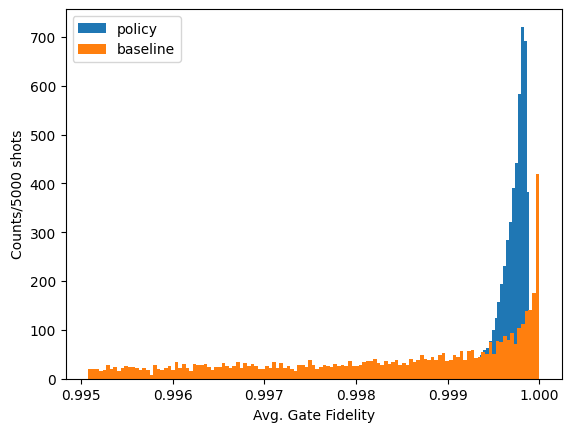

In [96]:
policy_fidelity = 1 - 10**(-np.array(policy_reward))
baseline_fidelity = 1 - 10**(-np.array(baseline_reward))

plt.hist(policy_fidelity, label='policy', bins=25)
plt.hist(baseline_fidelity, label='baseline', bins=125)
plt.xlabel('Avg. Gate Fidelity')
plt.ylabel('Counts/5000 shots')
plt.legend()
plt.show()

In [97]:
import pandas as pd

In [98]:
df_histogram = pd.DataFrame({
    "policy fidelity": policy_fidelity,
    "baseline fidelity": baseline_fidelity,
})
df_histogram.to_csv('histogram_fig')

In [103]:
print(np.array(avg_fidelity_history).shape)

(450,)


In [104]:
df_learning = pd.DataFrame({
    "per-cycle fidelity": single_rep_reward_history[:400],
    "reward": n_reps_channel_fidelity,
})
df_learning.to_csv('learning_fig')

In [56]:
policy_reward = []

for sample_obs in random_obs:
    next_obs = torch.Tensor(np.tile(sample_obs / np.pi, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.5

    obs, reward, terminated, truncated, info = ppo_agent.env.step(cpu_action)
    policy_reward.append(np.mean(reward))

/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9987374964380825
Reward (avg): 0.9573899957929383 Std: 0.016899131770985818
obs: [-0.75]
reward: [1.26957332 1.72491212 1.22930684 1.11213635 1.81515986 1.26762052
 1.17763268 1.14014371 1.71427791 1.25385364 1.26753283 1.29826637
 1.33387072 1.60315784 1.46385928 1.44879076 1.43337976 1.46078084
 1.36993164 1.622581   1.33849975 1.34087893 1.17385368 1.64667778
 1.66040946 1.3581248  1.68882018 1.30905754 1.21581103 1.54680231
 1.54835738 1.26669194]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
obs: [0.25]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9984011133456023


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9966457384697965 Std: 0.011090718780273618
obs: [0.25]
reward: [1.9407904  1.77491624 2.24335886 2.602282   2.4360666  1.74189298
 6.         6.         2.86372222 1.99134698 6.         1.65305284
 6.         2.20225305 2.30206921 2.37836381 3.36394328 6.
 1.64724347 6.         2.0430334  2.19310895 6.         1.72574043
 1.89568396 2.11774537 6.         6.         2.81438148 2.24666967
 6.         1.9012628 ]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
obs: [0.25]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9984011133456023


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1032ba5d0>>
Traceback (most recent call last):
  File "/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Reward (avg): 0.984405854293545 Std: 0.0138118489503998
obs: [0.25]
reward: [2.08400916 1.54829884 1.70587268 6.         1.77449967 1.76835571
 1.63225045 1.45604714 2.17136464 1.48216267 2.53854727 1.73583308
 1.50693227 6.         1.69560506 1.74248276 1.74226748 2.71769161
 1.59233864 1.64185674 2.09471292 2.15852604 1.36299495 1.3596249
 6.         1.73265782 2.51965372 1.66410376 2.34159498 1.67553021
 1.9814617  6.        ]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141
Reward (avg): 0.9907717146094117 Std: 0.016144362459204916
obs: [0.125]
reward: [2.60606669 6.         6.         1.82191987 1.61146091 6.
 1.55733385 2.30008685 1.60706016 6.         6.         1.94996008
 1.54042349 6.         1.46127431 2.42919037 6.         1.65443156
 1.55025003 1.56440896 6.         1.66564176 6.         1.85903013
 6.         1.44420112 1.9855007  2.39884897 6.         1.95870907
 1.44184816 6.        ]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -0.39269908  0.          0.          0.        ]
Environment Observation: [-0.125]
obs: [-0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996828848294644


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9846197605760618 Std: 0.015889383127616313
obs: [-0.125]
reward: [2.13565967 1.62052493 1.25866553 3.10364149 1.69283707 1.74021553
 1.81446023 2.1240397  2.21766618 2.25033401 1.32237137 1.63879458
 6.         1.870069   1.65015025 6.         2.0623263  1.79534377
 1.87028661 1.68671503 1.46165029 6.         1.75054937 1.37177922
 1.65551337 1.73841577 6.         1.68837051 1.5533139  6.
 6.         1.59428465]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -0.39269908  0.          0.          0.        ]
Environment Observation: [-0.125]
obs: [-0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996828848294644


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9919985328674572 Std: 0.017523255305442853
obs: [-0.125]
reward: [6.         1.86372216 1.53802409 1.95549431 6.         2.06631334
 1.65967674 1.64988639 2.18174125 6.         6.         1.56408082
 6.         1.53611206 6.         1.42118122 3.47210509 1.7528501
 2.56995961 1.67672917 1.96272652 6.         1.90723014 1.41715689
 6.         6.         1.91855903 6.         1.61300663 1.59335074
 1.90976026 2.25186481]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9999446586076985 Std: 0.014470695347690937
obs: [0.125]
reward: [6.         6.         6.         2.03980639 1.63805516 1.57343174
 6.         2.05856079 6.         6.         2.48001146 2.0169839
 3.49365485 6.         6.         2.17909572 6.         1.82199243
 6.         3.45189421 6.         2.3398525  6.         6.
 3.34264143 3.14623097 2.1715527  1.88835936 1.85291563 1.65507292
 6.         1.83988706]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
obs: [0.375]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9976663207003125
Reward (avg): 0.9345509507275118 Std: 0.015252977370203353
obs: [0.375]
reward: [1.14366963 1.20367038 1.1206352  1.2724841  1.23206951 1.19732504
 1.32468235 1.06691229 1.18334093 1.09723624 1.14379097 1.23926401
 1.08470592 1.45334953 1.06677727 1.31872076 1.18939227 1.32273947
 1.17235648 1.05384996 1.38561926 1.35566472 1.00905595 1.09937853
 1.30168474 1.26496822 1.14323698 1.15504879 1.08302728 1.12149125
 1.21598699 1.26923936]
batch action shape: (32, 7)
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [0.]
obs: [0.]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9994095898036143


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9768938656805982 Std: 0.010252088822258846
obs: [0.]
reward: [2.26251864 1.55626632 2.04961343 1.4679244  1.43338467 1.59477121
 2.10116197 1.9208541  1.42975815 1.57989225 1.6319497  1.52174995
 1.6625054  1.48815116 1.48826496 1.50024953 1.62442711 1.52251801
 1.62753034 1.62274576 1.52305302 1.59044744 1.41718935 1.95350519
 1.55649959 2.17562894 1.96074676 1.49647908 2.05125277 2.60985538
 1.54211761 1.65398338]
batch action shape: (32, 7)
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [0.]
obs: [0.]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9994095898036143


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9932668843867489 Std: 0.013555065887895753
obs: [0.]
reward: [6.         1.88481576 2.2616019  1.7461115  2.18483938 2.17809229
 6.         1.85244385 1.61988793 2.38753816 2.12869721 2.32855635
 1.36015396 6.         6.         1.68787554 2.29645377 6.
 1.817989   2.59564758 1.89225903 2.20895893 6.         1.57794739
 1.91721121 1.97974135 1.79847067 6.         1.90365072 6.
 6.         1.87940882]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
obs: [0.375]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9976663207003125


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9210281448755755 Std: 0.016863503628499116
obs: [0.375]
reward: [1.09387147 1.25897267 1.0670338  1.04307282 1.1928585  1.30117437
 1.08149561 0.99033185 1.06029515 1.01322311 1.02401389 1.15202297
 0.9660716  0.99412828 1.06993472 1.10043337 1.18387586 1.04149415
 1.19103515 1.1690634  1.20086174 1.00441158 1.22570804 1.06256512
 1.17667434 1.29157725 1.24992669 0.94549569 1.04816214 1.15371028
 1.10858122 1.14615394]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
obs: [0.375]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9976663207003125
Reward (avg): 0.999836094475363 Std: 0.01352091101879157
obs: [0.375]
reward: [6.         6.         6.         6.         2.33391193 1.87043201
 1.57412709 3.04385137 1.69583607 2.28808711 6.         2.10741816
 6.         1.7335022  2.04816131 6.         2.71573363 6.
 1.76592933 3.30597189 6.         6.         6.         2.66736151
 6.         6.         2.19200635 2.92565566 2.20890841 3.25216559
 2.01565109 1.76560815]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141
Reward (avg): 0.9853138402159405 Std: 0.010362838367763331
obs: [0.125]
reward: [2.06874131 1.96231745 1.60459466 2.15589059 1.49399138 1.64771678
 2.37246999 6.         6.         1.58581162 6.         1.92830849
 2.02298468 1.58997391 1.56640187 1.96132617 1.56717487 1.6623085
 1.90941105 1.45984716 1.83858433 2.20614977 2.2672375  2.10373554
 2.0741716  1.91800042 1.65562261 1.80091993 1.50236891 1.73752231
 1.79126473 2.37213784]
batch action shape: (32, 7)
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment Observation: [0.]
obs: [0.]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9994095898036143


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9857851810137135 Std: 0.01245548123976197
obs: [0.]
reward: [2.13800904 1.86107248 6.         1.73872162 6.         2.15911598
 1.68122849 2.10162717 1.7635809  1.63240276 1.66309112 1.55718195
 1.87902567 1.5140164  1.62213485 1.7297633  1.89250883 2.67065872
 2.23448364 1.72963248 2.13253864 1.51104931 1.83426444 1.88842262
 1.60698762 1.8770577  6.         1.71068614 1.55316221 2.23658056
 2.01970947 1.41539482]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9689191732275972 Std: 0.015063833403415586
obs: [0.125]
reward: [1.38917264 1.52847165 1.29875017 1.34476576 1.39009056 1.40930883
 1.6600745  1.46566151 1.34418408 1.44455662 2.32010741 1.3846052
 2.46159569 1.57155849 1.6278119  1.31076945 2.1847919  1.56264388
 2.25664858 1.4883373  1.4109616  1.39612769 1.28683321 1.41642035
 1.72956641 1.85620859 1.32179577 1.49508737 2.27819945 1.57184448
 1.23463053 1.71053338]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
obs: [-0.875]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9980865563463424


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.8389859824516277 Std: 0.018570330879623908
obs: [-0.875]
reward: [0.83542338 0.75587745 0.66626162 0.82268556 0.77075397 0.8099938
 0.82719783 0.90281601 0.79580441 0.77165451 0.77188599 0.82444768
 0.74991303 0.76434107 0.77502624 0.8025443  0.74444742 0.81419602
 0.78125028 0.83870421 0.77216516 0.81565802 0.86496787 0.85776612
 0.78310048 0.70995934 0.84475874 0.72363781 0.83766229 0.78760957
 0.87309899 0.77478321]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -1.96349541  0.          0.          0.        ]
Environment Observation: [-0.625]
obs: [-0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9992346785868589


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9882574345246384 Std: 0.012658230833227296
obs: [-0.625]
reward: [2.32044207 2.54880669 1.95207792 2.39106563 1.61948955 6.
 2.0566014  6.         1.64802566 1.61177606 3.18708156 6.
 1.76614561 2.05244013 1.53428846 2.0408149  1.889798   1.58703136
 2.23644449 6.         2.36215905 1.84141499 1.67272198 1.54079526
 6.         1.49353031 1.53531925 1.75592051 1.62479203 2.29859503
 1.72188301 1.8843609 ]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
obs: [0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9957370428507171


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9954935451735543 Std: 0.012276255031848144
obs: [0.625]
reward: [2.47193874 6.         1.88549516 1.98378704 6.         2.27119553
 6.         1.5802373  2.48704117 1.96906239 6.         1.75305656
 1.90285496 6.         6.         2.25651099 6.         2.06264316
 2.02333099 1.81198174 2.08554498 2.09488943 2.3116757  6.
 2.01244792 6.         1.54733877 6.         1.55809364 1.94908723
 6.         2.12492343]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
obs: [0.5]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9967781830706965


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 1.001016885459158 Std: 0.011051425755580092
obs: [0.5]
reward: [6.         6.         6.         6.         1.93263862 2.20779738
 6.         2.73671252 2.2581264  1.73670496 6.         2.44814949
 1.56038007 6.         2.85198035 6.         6.         6.
 2.51972476 2.04532485 6.         6.         6.         6.
 6.         6.         2.44164953 1.61245159 2.61651906 6.
 6.         6.        ]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -0.39269908  0.          0.          0.        ]
Environment Observation: [-0.125]
obs: [-0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996828848294644


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9809105227374595 Std: 0.014540806808413185
obs: [-0.125]
reward: [1.46213181 1.43434319 1.42116527 1.64419519 1.90468127 1.90878119
 6.         1.46172629 1.45113719 2.40353595 2.15983842 2.66576208
 1.6320152  3.28431222 1.51214994 1.59142401 1.7116454  1.64488245
 1.64851533 2.42533436 1.58763955 1.81995663 6.         1.65548985
 6.         6.         1.82716545 1.30033911 1.74436367 1.35349105
 1.59679988 1.67831903]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
obs: [0.375]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9976663207003125


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9912676824175429 Std: 0.016242727134439614
obs: [0.375]
reward: [1.46835385 1.63836598 6.         6.         1.65816574 1.58220409
 1.75519022 6.         1.72839417 1.99376491 6.         1.66929649
 2.00535656 6.         1.66092371 2.79034888 1.58808114 6.
 1.66073983 1.93111709 1.56239884 6.         1.48299011 1.89532988
 2.6555218  2.08767879 1.70630884 1.90513263 1.97618014 6.
 6.         1.88180055]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9891621298268347 Std: 0.01683254258923366
obs: [0.125]
reward: [3.04559069 1.74174151 1.48118721 1.5801677  1.6961195  1.87395591
 2.92370679 6.         6.         6.         1.36638105 6.
 1.5452314  1.37977709 2.12406386 1.82608819 2.74564192 1.79266919
 1.57770272 6.         2.08780336 1.59652001 1.65991892 2.00577417
 2.25483816 1.80904269 1.69793942 1.84370951 2.3041988  1.73450313
 6.         6.        ]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
obs: [-1.]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9972821092614348


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9498765969796288 Std: 0.012689023600513986
obs: [-1.]
reward: [1.46053927 1.21979168 1.2189522  1.39211615 1.33098215 1.2634892
 1.30555168 1.33234751 1.21528444 1.24684039 1.43396969 1.47075863
 1.22178662 1.26922231 1.42878584 1.29840144 1.13501772 1.36579167
 1.35152639 1.29798785 1.59752021 1.27984443 1.26126619 1.53723999
 1.47921402 1.16089541 1.14702003 1.21457464 1.20996022 1.45608798
 1.32521558 1.15435627]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
obs: [0.25]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9984011133456023


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9352161702161381 Std: 0.016715530449537056
obs: [0.25]
reward: [1.32607791 1.2603137  1.42700079 1.00571065 1.01740032 1.51789003
 1.12032331 1.07369774 1.18115049 1.30211139 1.25943056 1.15457231
 1.16543138 1.06299696 1.26591557 1.18288601 1.17434832 1.22791011
 1.13542961 1.17316405 1.21754392 1.33825563 1.24153481 1.08128295
 1.45076216 1.15371052 1.01844289 1.2043841  1.19063427 1.11183284
 1.26037556 1.22947308]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
obs: [0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9957370428507171


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9545427025369774 Std: 0.018468327862082766
obs: [0.625]
reward: [1.36528171 1.06273696 2.35857909 2.32307486 1.43680898 1.25485348
 1.28180124 1.10845947 1.31939932 1.19146097 1.414557   1.41610521
 1.112146   1.36782425 1.20831223 1.47382872 1.22856771 1.4451453
 1.76345047 1.51662016 1.27397753 1.36411866 1.51283642 1.49351748
 1.34958195 1.32539966 1.33510306 1.25173968 1.30290372 1.18745061
 1.58844665 1.2831046 ]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -1.96349541  0.          0.          0.        ]
Environment Observation: [-0.625]
obs: [-0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9992346785868589


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9728905144144461 Std: 0.012736673857692407
obs: [-0.625]
reward: [1.439272   1.50198163 1.69628688 1.95797098 1.39770853 1.54961665
 1.52250956 1.70303726 1.25903424 1.6495666  1.93397829 1.46170098
 1.48348992 1.49208464 1.61760511 1.84117961 1.31424883 1.43522818
 1.58046451 1.37359715 1.76377946 1.36277871 1.50999752 1.53486799
 2.15320441 2.90047854 1.80615446 1.597944   1.6247276  2.46334842
 1.3586665  1.54347413]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         2.74889357 0.         0.         0.        ]
Environment Observation: [0.875]
obs: [0.875]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.993197418987835


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.8780620206987352 Std: 0.01903562873086829
obs: [0.875]
reward: [0.96559448 0.88356443 0.9800352  1.00346796 0.8955101  0.89854896
 0.8349417  0.83145775 0.84283733 0.89336966 0.8911472  0.99946969
 0.9129277  0.97990805 0.87407975 0.84124834 0.90946641 1.07095347
 0.94533301 0.83564299 0.91618225 0.98735812 0.92099561 0.97529736
 0.81047431 0.83450612 0.90101054 0.92872401 0.81797688 1.07244709
 0.98904787 0.97528061]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
obs: [0.5]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9967781830706965


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.979644726297382 Std: 0.012401118482526082
obs: [0.5]
reward: [1.8736889  1.97688349 1.66585672 1.53622206 1.57044507 1.46087132
 6.         1.57610387 1.67346417 1.45657227 1.45137124 1.94044653
 1.39041431 1.59200806 1.81247917 1.81635115 1.72049334 1.59762003
 1.40900728 2.04520706 1.53732649 1.50925789 2.66789733 1.90427025
 1.56874797 1.49823303 6.         1.65663699 1.80157467 6.
 1.72478349 1.62656673]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
obs: [0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9957370428507171


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.946543679883851 Std: 0.01286055872648431
obs: [0.625]
reward: [1.41314283 1.26559906 1.26106552 1.25285348 1.47645929 1.30808029
 1.24830369 1.25456933 1.44532379 1.28506809 1.10943914 1.23874923
 1.59397082 1.23450917 1.26756798 1.37316567 1.21559205 1.1512415
 1.28636405 1.28950501 1.28703255 1.15008293 1.09961458 1.20276049
 1.32558033 1.40568664 1.43259631 1.13586596 1.38141067 1.3579488
 1.1860325  1.20226074]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -0.39269908  0.          0.          0.        ]
Environment Observation: [-0.125]
obs: [-0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9996828848294644


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9992619592920728 Std: 0.020188270291744647
obs: [-0.125]
reward: [1.74704424 2.49028411 6.         6.         2.83940041 6.
 6.         6.         6.         1.44615733 1.51257043 6.
 2.05258607 1.61870176 6.         6.         6.         6.
 6.         1.9344796  1.5525284  6.         2.54172727 6.
 1.53581581 6.         1.75425488 6.         2.03027375 1.82833274
 1.48827947 1.68086091]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9822378672985413 Std: 0.014502560157199501
obs: [0.125]
reward: [1.89842206 2.85173718 1.53332315 1.5645151  1.53125449 1.54686424
 2.07075926 1.70310271 1.55703735 1.75659989 1.94576191 1.37237802
 1.66486189 2.05010384 1.66057926 1.48261046 1.7749615  1.69060778
 3.00615679 1.3715553  6.         1.87667068 6.         1.50523374
 1.35055148 1.66834734 1.9390615  6.         1.83046517 1.65575536
 2.33898929 1.75651603]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
obs: [0.25]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9984011133456023


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9900037121392877 Std: 0.01722083723074806
obs: [0.25]
reward: [1.98214643 6.         1.64014674 1.60779661 1.55310642 2.39639137
 1.60901773 1.46460314 2.8968515  1.51128578 6.         2.3021342
 1.57722287 1.73814214 6.         1.61644042 6.         1.71516062
 2.09527979 1.29359102 6.         1.68818277 6.         1.74926306
 6.         1.82230605 6.         1.76139213 6.         1.88361493
 6.         6.        ]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
obs: [0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9957370428507171


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.8835602780530654 Std: 0.016017242115348072
obs: [0.625]
reward: [0.90495384 0.95933296 0.88183844 0.87332538 0.88263817 1.08475827
 0.85814731 0.95260809 0.93386045 0.99536943 0.87641618 0.90050107
 0.96016622 0.88870013 0.91721423 0.9571857  1.01062223 0.79070221
 0.98563085 0.98685169 1.00723255 0.95443899 0.94125845 0.96724369
 1.01156812 0.92496354 0.86817153 1.02354709 0.95503586 0.92184786
 0.96526317 0.87356077]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -1.96349541  0.          0.          0.        ]
Environment Observation: [-0.625]
obs: [-0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9992346785868589


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.913451879641351 Std: 0.012977699009437182
obs: [-0.625]
reward: [1.00988443 1.07440673 0.97968399 1.09526152 0.95635059 1.04950606
 1.1623709  1.04853647 0.99281141 1.01565501 1.00879887 1.00526152
 1.07189797 1.07786176 1.17608109 1.10233749 1.04634719 1.13229418
 1.25010454 1.02723039 1.13099287 1.02357476 0.93882842 1.0897165
 1.1550231  1.03604101 1.06211896 1.10797832 1.10623552 1.144073
 1.04113406 1.05120094]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         2.74889357 0.         0.         0.        ]
Environment Observation: [0.875]
obs: [0.875]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.993197418987835


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.826499125568997 Std: 0.01180959311791219
obs: [0.875]
reward: [0.73690501 0.7505592  0.71114542 0.74938865 0.80943565 0.76356161
 0.78641402 0.77251587 0.78258561 0.74228542 0.79128564 0.74717267
 0.75490423 0.73222365 0.76750531 0.79105795 0.76870933 0.75915667
 0.75997673 0.72779665 0.73495954 0.73407557 0.77165929 0.76850532
 0.67571886 0.80223914 0.80443809 0.77299372 0.76696237 0.75592124
 0.8146954  0.7669213 ]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -1.96349541  0.          0.          0.        ]
Environment Observation: [-0.625]
obs: [-0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9992346785868589


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9353477001340618 Std: 0.018533157519715984
obs: [-0.625]
reward: [1.23820434 1.06275785 1.61907107 1.11741076 1.34954341 0.94437939
 1.38947814 1.36225183 1.12360405 1.33037533 1.08137267 1.26203546
 1.15485041 1.2571228  1.07937062 1.25824348 1.21803121 1.19161035
 1.23076726 1.3101443  1.3656284  1.09862348 1.14296811 1.12977462
 1.46325881 1.16013544 1.11956348 1.19172145 1.09991927 1.01824759
 1.14406001 1.18169437]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.98838070584669 Std: 0.016338000402945963
obs: [0.125]
reward: [1.62803572 1.39871119 3.89215105 6.         2.19088293 1.67901518
 6.         1.748466   1.85488907 1.57333202 1.88451739 2.11724767
 1.452725   1.68085677 6.         1.41663472 6.         1.79520696
 6.         1.49971202 1.55396285 1.55189712 6.         2.13015844
 1.56373266 6.         1.73312558 1.86162124 6.         1.76283146
 6.         2.68561638]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         2.74889357 0.         0.         0.        ]
Environment Observation: [0.875]
obs: [0.875]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.993197418987835


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9378914114030299 Std: 0.020069473747910717
obs: [0.875]
reward: [1.0656389  1.11751223 1.08085334 1.32405686 1.21866317 1.14911681
 1.15537349 1.30109929 1.73455122 1.44487961 1.09376988 1.20580769
 1.04807687 1.30237692 1.42655744 1.32637817 0.965568   1.27424064
 1.20786696 1.10393343 1.1527282  1.17801486 1.37090107 1.12078599
 1.16805521 1.05908915 1.23105114 1.7480294  1.25261032 1.22719806
 1.1111749  1.38897931]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9890410210053853 Std: 0.015251388708265413
obs: [0.125]
reward: [1.94118623 1.32961605 1.84591519 1.41447452 1.96605432 1.87426719
 2.51310356 6.         2.00590571 1.54730988 1.80970861 6.
 1.40674287 2.31160104 2.25190952 2.4362664  1.9875803  6.
 1.9085084  1.76571279 1.80171862 6.         6.         1.42429794
 6.         1.94302483 6.         1.88081315 1.79352262 2.26482972
 1.60683002 6.        ]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
obs: [1.]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9916999144182752


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.8035798879668101 Std: 0.01279179675279943
obs: [1.]
reward: [0.73226547 0.68584415 0.69843483 0.68988958 0.7069247  0.73871151
 0.72701662 0.70452012 0.71375662 0.75937579 0.74380099 0.71960268
 0.72524372 0.72771268 0.70326065 0.7061153  0.6516191  0.67017571
 0.68261075 0.69619255 0.71782091 0.68104871 0.69987333 0.70190859
 0.75700627 0.70935081 0.71252763 0.62691745 0.68913177 0.7381519
 0.72620918 0.70366273]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
obs: [0.5]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9967781830706965


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9479333120476074 Std: 0.012408597007215232
obs: [0.5]
reward: [1.26775159 1.28075401 1.38352423 1.3128705  1.42907726 1.48473159
 1.183737   1.11651757 1.16670144 1.21604402 1.31735919 1.49541603
 1.25434888 1.20912123 1.27832488 1.27418015 1.18784885 1.22923982
 1.45269488 1.29475125 1.51716269 1.58474946 1.28955017 1.35849145
 1.25084558 1.24345411 1.23424464 1.37415018 1.16074215 1.28236003
 1.23457024 1.15059751]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
obs: [0.5]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9967781830706965


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.8855367299726749 Std: 0.014922123247439885
obs: [0.5]
reward: [0.98951933 0.87538323 1.00390857 0.93403006 0.91207694 0.94800335
 0.94957628 0.989713   0.98835134 0.89097099 0.86733793 0.93342313
 0.88702363 1.02598905 1.05480341 0.82621384 1.02614724 0.98302849
 1.02693791 0.92253854 1.02189751 0.9413571  0.87844739 0.98157459
 0.90424282 0.95782164 0.89160041 0.87612584 0.93300226 0.88365738
 0.98916918 0.94694848]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
obs: [0.375]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9976663207003125


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9858325043084502 Std: 0.014381565325949527
obs: [0.375]
reward: [3.04448866 1.97907539 1.91549313 1.89732051 1.70705439 1.48561525
 1.51371332 6.         6.         1.85715938 1.99848048 1.56783687
 1.84611514 2.89404673 1.60901668 2.3666512  1.6820459  1.53147381
 6.         1.91429523 1.47734062 1.67494635 1.470393   6.
 2.42630346 6.         6.         1.81633351 1.40704783 1.67282529
 1.77920375 1.44504759]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
obs: [-0.875]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9980865563463424


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9614561067965224 Std: 0.014964012524545047
obs: [-0.875]
reward: [1.19015201 1.54420272 1.54926426 1.48575248 1.57549021 1.46911507
 1.37149218 1.54924672 1.08807561 1.42604356 1.39876098 1.2635035
 1.23910196 1.24186027 1.3643441  1.39432727 1.54235299 1.33711181
 1.44091609 1.40545285 1.47299243 1.21712248 1.47589838 1.48303747
 1.45546791 1.97314314 1.57989165 1.78686293 1.55494733 1.43011236
 1.25136968 1.80187327]
batch action shape: (32, 7)
Sampled angles:  [ 0.          0.         -0.78539816  0.          0.          0.        ]
Environment Observation: [-0.25]
obs: [-0.25]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9998020574471296


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9904260896418728 Std: 0.016544303534571782
obs: [-0.25]
reward: [2.17632437 2.16805411 3.85418848 6.         1.21730869 1.43026651
 6.         6.         2.10073137 3.18885146 1.83421313 1.6039584
 6.         6.         6.         1.7064879  1.68287964 6.
 1.52036839 3.36743214 1.90282084 1.68531848 6.         1.83003589
 1.43842941 1.89966739 2.06012167 6.         3.3454108  2.12957281
 2.22671677 1.58917553]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
obs: [0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9957370428507171


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9909346080804246 Std: 0.021097078406494912
obs: [0.625]
reward: [6.         6.         2.05837982 1.20932814 6.         2.00044301
 6.         2.41538298 6.         6.         2.04762837 1.3856383
 1.57159452 1.80054374 1.9336436  6.         1.67301764 1.33037956
 2.60534365 6.         6.         1.70698276 1.66603147 1.37124478
 1.83055701 6.         1.54892189 1.72962165 6.         6.
 1.66412166 2.23961208]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9943324950758371 Std: 0.014451988462443853
obs: [0.125]
reward: [1.9795717  6.         1.55736749 1.84363512 2.21558962 6.
 6.         1.85923823 1.64442839 2.62654682 1.62201395 6.
 6.         6.         1.81964395 6.         6.         2.07114444
 1.98623481 6.         6.         2.35760564 1.62949375 1.44273414
 1.8970379  6.         1.7654137  2.47098104 1.64947772 2.2116901
 6.         1.80396432]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
obs: [0.25]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9984011133456023


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9965731499593864 Std: 0.01536734851653448
obs: [0.25]
reward: [1.56127334 2.13950538 2.09460783 2.00738184 6.         2.15030407
 6.         1.83856408 6.         6.         1.83784588 6.
 1.81845414 2.12051189 1.482832   1.65859702 1.59456498 2.35661567
 3.39469618 3.51027438 6.         2.00495788 1.8185799  1.97016483
 6.         1.70807193 2.21848488 6.         6.         6.
 6.         6.        ]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
obs: [0.25]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Finished simulation benchmark 

Gate Fidelity:  0.9984011133456023
Reward (avg): 1.0045665775613166 Std: 0.011937417091881447
obs: [0.25]
reward: [6.         6.         1.79063735 6.         6.         6.
 6.         6.         2.59606178 6.         6.         6.
 6.         1.55858408 6.         2.72367872 6.         3.63137965
 6.         2.06225201 6.         2.61150747 1.88691198 6.
 6.         6.         3.21008265 2.09762228 6.         6.
 2.08156103 2.77980325]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         0.39269908 0.         0.         0.        ]
Environment Observation: [0.125]
obs: [0.125]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelity:  0.9989822777300141


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Reward (avg): 0.9845329215845657 Std: 0.01802642749593382
obs: [0.125]
reward: [1.66684227 6.         1.79600831 6.         1.81829682 2.59733358
 1.52524675 1.49550056 1.54376046 6.         1.73934063 1.5457062
 1.59328136 1.37821738 2.14232777 1.69348011 1.6177211  6.
 1.95509721 1.73503533 1.74118416 2.08998117 2.32242566 1.30853318
 6.         1.95987189 1.49257633 1.68967215 1.57025017 1.55609631
 1.47240476 1.99417648]
batch action shape: (32, 7)
Sampled angles:  [0.         0.         1.96349541 0.         0.         0.        ]
Environment Observation: [0.625]
obs: [0.625]
reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/chatt07/Desktop/envs_10/contextual_env_/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


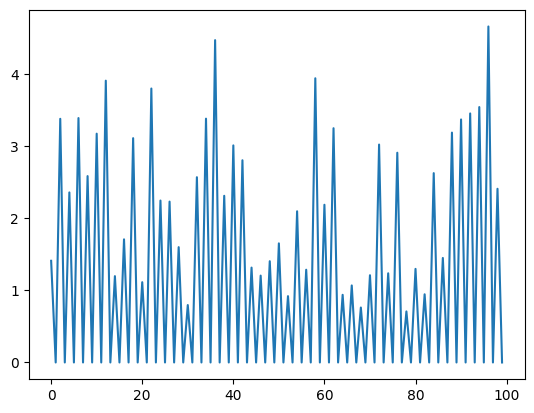

In [58]:
plt.plot(policy_reward)

In [42]:
# Visualizing Policy wrt actions

import torch

full_actions = []
actions = []
std_actions = []

for sample_obs in ppo_agent.env.unwrapped.discrete_obs_vals:
    next_obs = torch.Tensor(np.tile(sample_obs / np.pi, (ppo_agent.num_envs, 1)))
    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    cpu_action = np.clip(
        cpu_action,
        -1,
        1.
        # ppo_agent.env.action_space.low,
        # ppo_agent.env.action_space.high,
    )
    cpu_action *= 0.5
    full_actions.append(cpu_action)
    actions.append(np.mean(cpu_action, axis=0))
    std_actions.append(np.std(cpu_action, axis=0))

In [43]:
print(std_actions)

[array([0.02442645, 0.05142608, 0.04841775, 0.02217453, 0.05625414,
       0.04690738, 0.04924858], dtype=float32), array([0.02481361, 0.05020547, 0.05659451, 0.02405551, 0.05803358,
       0.02947876, 0.0455525 ], dtype=float32), array([0.02097624, 0.04793904, 0.04246252, 0.02560366, 0.05494981,
       0.04165993, 0.03337122], dtype=float32), array([0.02389484, 0.04858362, 0.05089067, 0.02208002, 0.05969154,
       0.05606677, 0.04669387], dtype=float32), array([0.03184383, 0.04997031, 0.04657834, 0.02351565, 0.05434164,
       0.05114567, 0.03319458], dtype=float32), array([0.02505149, 0.05952622, 0.05672057, 0.01688203, 0.0557627 ,
       0.04616775, 0.04312882], dtype=float32), array([0.0251    , 0.04964823, 0.04393209, 0.01955145, 0.05200859,
       0.03935638, 0.0429288 ], dtype=float32), array([0.02015489, 0.0504274 , 0.05577603, 0.02095532, 0.05716373,
       0.0444812 , 0.04137832], dtype=float32), array([0.0249218 , 0.05830084, 0.06129043, 0.02114215, 0.05647268,
       0.045

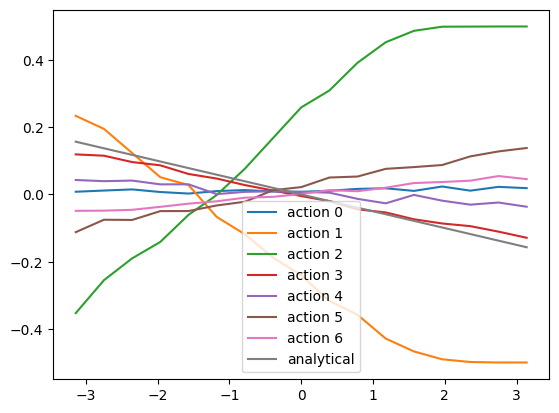

In [45]:
actions = np.array(actions)

o_vals = ppo_agent.env.unwrapped.discrete_obs_vals
ana_sum = -o_vals * 0.05

for i in range(len(actions[0])):
    plt.plot(o_vals, actions[:,i], label=f'action {i}')
# plt.plot(o_vals, (actions[:,1] - actions[:,2]) * np.pi, label=f'sum')
plt.plot(o_vals, ana_sum, label=f'analytical')
plt.legend()
plt.show()

In [46]:
single_n_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[1,],
        n_shots=10,
        sampling_paulis=100,
        c_factor=1,
        seed=seed + 6,
        n_reps_mode="sequential",
        control_flow_enabled=False,
    ),
    reward="fidelity",
    env_metadata=env_metadata,
)

single_n_q_env = OneParamAngleSpilloverEnv(
    single_n_env_config, 
    unbound_circuit_context=circuit, 
    gamma_matrix=gamma_matrix, 
    num_params=17,
    discrete_history_length=3,
    circuit_param_distribution="moving_discrete",
    optimal_error_precision=1e-5
)

Observation Vals: [-3.14159265 -2.74889357 -2.35619449 -1.96349541 -1.57079633 -1.17809725
 -0.78539816 -0.39269908  0.          0.39269908  0.78539816  1.17809725
  1.57079633  1.96349541  2.35619449  2.74889357  3.14159265]


In [50]:
# Testing fidelity of agents

import copy

rewards = []

action_test = copy.deepcopy(actions) * 0.5

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    # act[3] = ana_sum[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    rewards.append(np.mean(reward))

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9998556158545414
Reward (avg): 0.9998556158545414 Std: 0.0
obs: [-1.]
reward: [3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049 3.84048049
 3.84048049 3.84048049]
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9998392683841996
Reward (avg): 0.9998392683841996 Std: 0.0
obs: [-0.875]
reward: [3.793898

In [51]:
baseline_rewards = []

# action_test = copy.deepcopy(actions)

for i, sample_obs in enumerate(ppo_agent.env.unwrapped.discrete_obs_vals):
    next_obs = torch.Tensor(np.tile(sample_obs, (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    act[3] = 0.
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    baseline_rewards.append(np.mean(reward))

Sampled angles:  [ 0.          0.         -3.14159265  0.          0.          0.        ]
Environment Observation: [-1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9950753362380551
Reward (avg): 0.9950753362380551 Std: 0.0
obs: [-1.]
reward: [2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342 2.30762342
 2.30762342 2.30762342]
Sampled angles:  [ 0.          0.         -2.74889357  0.          0.          0.        ]
Environment Observation: [-0.875]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9962277361774309
Reward (avg): 0.9962277361774309 Std: 0.0
obs: [-0.875]
reward: [2.423397

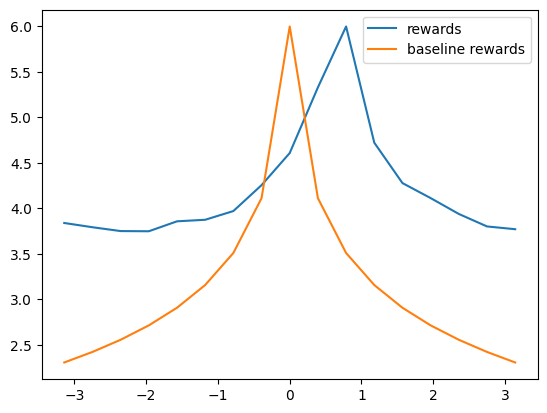

In [52]:
plt.plot(single_n_q_env.discrete_obs_vals, rewards, label='rewards')
plt.plot(single_n_q_env.discrete_obs_vals, baseline_rewards, label='baseline rewards')
plt.legend()
plt.show()

In [60]:
# Testing baseline vs optimal fidelities

from torch import Tensor

fidelity_history = []
baseline_history = []
n_angles = 100
phi_array = np.zeros((n_angles, len(q_env.circuit_parameters)))
actions_array = np.zeros((n_angles, 7))


for i in range(n_angles):
    obs, info = ppo_agent.env.reset()
    next_obs = torch.Tensor(np.tile(obs, (ppo_agent.num_envs, 1)))

    action, logprob, _, value = ppo_agent.agent.get_action_and_value(
        next_obs
    )
    cpu_action = action.cpu().numpy()
    actions_array[i] = np.mean(cpu_action, axis=0)
    phi_array[i] = obs
    # cpu_action = np.clip(
    #     cpu_action,
    #     -1,
    #     1.
    #     # ppo_agent.env.action_space.low,
    #     # ppo_agent.env.action_space.high,
    # )

Sampled angles:  [ 0.          0.         -1.57079633  0.          0.          0.        ]
Environment Observation: [-0.5]
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
Sampled angles:  [0.         0.         1.17809725 0.         0.         0.        ]
Environment Observation: [0.375]
Sampled angles:  [0.         0.         2.74889357 0.         0.         0.        ]
Environment Observation: [0.875]
Sampled angles:  [ 0.          0.         -1.17809725  0.          0.          0.        ]
Environment Observation: [-0.375]
Sampled angles:  [0.         0.         1.57079633 0.         0.         0.        ]
Environment Observation: [0.5]
Sampled angles:  [0.         0.         0.78539816 0.         0.         0.        ]
Environment Observation: [0.25]
Sampled angles:  [0. 0. 0. 0. 0. 0.]
Environment

In [61]:
print(phi_array)
print(actions_array)

[[-0.5   -0.5   -0.5   -0.5   -0.5   -0.5  ]
 [ 0.375  0.375  0.375  0.375  0.375  0.375]
 [ 0.25   0.25   0.25   0.25   0.25   0.25 ]
 [ 0.375  0.375  0.375  0.375  0.375  0.375]
 [ 0.875  0.875  0.875  0.875  0.875  0.875]
 [-0.375 -0.375 -0.375 -0.375 -0.375 -0.375]
 [ 0.5    0.5    0.5    0.5    0.5    0.5  ]
 [ 0.25   0.25   0.25   0.25   0.25   0.25 ]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.75   0.75   0.75   0.75   0.75   0.75 ]
 [ 0.625  0.625  0.625  0.625  0.625  0.625]
 [-0.125 -0.125 -0.125 -0.125 -0.125 -0.125]
 [ 0.     0.     0.     0.     0.     0.   ]
 [ 0.625  0.625  0.625  0.625  0.625  0.625]
 [-0.875 -0.875 -0.875 -0.875 -0.875 -0.875]
 [-0.625 -0.625 -0.625 -0.625 -0.625 -0.625]
 [-0.125 -0.125 -0.125 -0.125 -0.125 -0.125]
 [ 0.25   0.25   0.25   0.25   0.25   0.25 ]
 [-0.5   -0.5   -0.5   -0.5   -0.5   -0.5  ]
 [ 0.5    0.5    0.5    0.5    0.5    0.5  ]
 [ 0.125  0.125  0.125  0.125  0.125  0.125]
 [-0.25  -0.25  -0.25  -0.25  -0.25  -0.25 ]
 [ 0.     

In [62]:
rewards = []

action_test = copy.deepcopy(actions_array) * 0.5
policy_rewards = []

for i in range(n_angles):
    next_obs = torch.Tensor(np.tile(phi_array[i], (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    # act[3] = ana_sum[i]
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    policy_rewards.append(np.mean(reward))

Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9864838973113066
Reward (avg): 0.9864838973113066 Std: 0.0
obs: [1.]
reward: [1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852 1.86914852
 1.86914852 1.86914852]
Sampled angles:  [0.         0.         3.14159265 0.         0.         0.        ]
Environment Observation: [1.]
batch action shape: (32, 7)
Starting simulation benchmark...
Finished simulation benchmark 

Gate Fidelities:  0.9984412067689521
Reward (avg): 0.9984412067689521 Std: 0.0
obs: [1.]
reward: [2.80721149 2.80721149 2.807211

In [ ]:
rewards = []

action_test = copy.deepcopy(actions_array) * 0.5
baseline_rewards = []

for i in range(n_angles):
    next_obs = torch.Tensor(np.tile(phi_array[i], (ppo_agent.num_envs, 1)))

    _obs, info = single_n_q_env.reset(seed=ppo_agent.seed, debug_obs=np.array([sample_obs]))
    act = action_test[i]
    act[0] = 0.
    act[1] = 0.
    act[2] = 0.
    act[3] = 0.
    act[4] = 0.
    act[5] = 0.
    act[6] = 0.
    batch_action = np.tile(act, (alt_q_env.batch_size, 1))
    obs, reward, terminated, truncated, info = single_n_q_env.step(batch_action)
    baseline_rewards.append(np.mean(reward))